# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from textwrap import dedent
import re
import warnings
from collections import defaultdict

warnings.filterwarnings("ignore")

##  - Parte 1

### 📌 Objetivo

En esta primera etapa del EDA, se busca consolidar todos los archivos `.csv` disponibles en una única estructura de datos y realizar un análisis de **completitud** para evaluar la calidad temporal de los registros de consumo eléctrico.


### 🗂️ 1. Concatenación de Archivos

Se cargan y concatenan todos los archivos individuales que contienen datos horarios de consumo eléctrico por vivienda. Esta etapa genera un único DataFrame llamado `merged_df`, que será la base para futuros análisis y modelos.

El resultado se guarda en `../data/vertical_raw_data_2.csv`.

### 📊 2. Análisis de Completitud de Datos

Por cada archivo original se verifica:
- Si las fechas en el nombre del archivo coinciden con los datos reales.
- Si existen **fechas faltantes** dentro del rango temporal.
- Si hay **días incompletos** (menos de 24 horas).
- Si hay **errores** de lectura o formato.

Se genera:
- Un reporte de texto con los resultados para cada archivo.
- Gráficos visuales por archivo que muestran la completitud diaria y mensual.
- Un resumen estadístico al finalizar el procesamiento.

Los resultados se guardan en `../data_analysis_results/`.

## 🔧 Limpieza de días incompletos

Además del análisis, se realizan acciones de limpieza para mejorar la calidad del dataset:
- Si un día tiene menos de 24 registros, se **rellenan** las horas faltantes con `ffill` o `bfill`.
- Si un día tiene **más de 24 registros**, se eliminan los duplicados conservando los primeros por hora.


In [2]:
folder_path = "data_raw/"
output_dir = "data_analysis_results/"
merged_output_path = "data/vertical_raw_data_2.csv"
os.makedirs(output_dir, exist_ok=True)

summary_stats = {
    'total_files': 0,
    'files_with_date_mismatch': 0,
    'files_with_missing_dates': 0,
    'files_with_incomplete_days': 0,
    'files_with_errors': 0,
    'cups_mismatches': defaultdict(int)
}

all_dataframes = []

In [3]:
def extract_dates_from_filename(filename):
    date_matches = re.findall(r'(\d{2}-\d{2}-\d{4})', filename)
    if len(date_matches) >= 2:
        try:
            return (datetime.strptime(date_matches[0], "%d-%m-%Y").date(),
                    datetime.strptime(date_matches[1], "%d-%m-%Y").date())
        except ValueError:
            pass
    return None, None

def extract_cups_from_filename(filename):
    cups_match = re.match(r'^([a-f0-9]+)', filename)
    return cups_match.group(1) if cups_match else "DESCONOCIDO"

def fix_incomplete_days(df):
    fixed_rows = []
    for date, group in df.groupby('fecha'):
        if len(group) < 24:
            full_day = pd.DataFrame({'hora': list(range(24))})
            merged = full_day.merge(group, on='hora', how='left')
            merged['fecha'] = date
            merged.sort_values(by='hora', inplace=True)
            merged.ffill(inplace=True)
            merged.bfill(inplace=True)
            fixed_rows.append(merged)
        elif len(group) > 24:
            trimmed = group.sort_values(by='hora').head(24)
            fixed_rows.append(trimmed)
        else:
            fixed_rows.append(group)
    return pd.concat(fixed_rows, ignore_index=True)


A su vez voy a preprocesar todas las columnas que quiero del dataset para que todas sigan un formato específico. Convertiré las columnas de fecha a a otra string pero con el mismo formato (formato dd/mm/yyyy). Transformare las columans de consumo_KWh y hora a float e int respectivamente para facilitar el trabajo con los datos.

In [4]:
contador_modificaciones = {}
total_modificaciones = 0

def formatear_hora(hora, cups=None):
    global contador_modificaciones, total_modificaciones
    hora_original = hora
    hora = str(hora).strip()
    modificado = False
    
    # Convertir '1:00' a '01:00', etc.
    if len(hora.split(':')[0]) == 1:
        hora = '0' + hora
        modificado = True
    
    # Eliminar '24:00:00' y '24:00' a '00:00' (formato más internacional)
    if hora == '24:00:00' or hora == '24:00':
        hora = '00:00'
    
    # Si se modificó y hay un CUPS, actualizamos el contador
    if modificado and cups is not None:
        contador_modificaciones[cups] = contador_modificaciones.get(cups, 0) + 1
        total_modificaciones += 1
        print(f"Advertencia: Hora modificada de '{hora_original}' a '{hora}' para el CUPS: {cups}")
    
    return hora

def limpiar_consumo(consumo):
    try:
        consumo = str(consumo).replace(',', '.')
        return float(consumo)
    except ValueError:
        print("HUBO ERROR")
        return float('nan')


In [5]:
def generate_report(file):
    cups = extract_cups_from_filename(file)
    file_path = os.path.join(folder_path, file)
    report_name = os.path.splitext(file)[0] + "_report.txt"
    report_path = os.path.join(output_dir, report_name)

    with open(report_path, 'w', encoding='utf-8') as f:
        f.write(dedent(f"""\
        ====================================
        ANÁLISIS DE COMPLETITUD DE DATOS
        Archivo: {file}
        CUPS: {cups}
        ====================================
        """))

        try:
            df = pd.read_csv(file_path, sep=';', dtype={"cups": str})

            df['fecha'] = pd.to_datetime(df['fecha'], format='mixed', dayfirst=True, errors='coerce').dt.strftime('%d/%m/%Y')
            df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y').dt.date
            df['consumo_kWh'] = df['consumo_kWh'].apply(limpiar_consumo)

            df['hora'] = df.apply(
                lambda row: formatear_hora(row['hora'], cups=row['cups'] if 'cups' in df.columns else None),
                axis=1)
            df['hora'] = pd.to_datetime(df['hora'], format='%H:%M', errors='coerce').dt.hour

            expected_start, expected_end = extract_dates_from_filename(file)
            if expected_start is None:
                raise ValueError("No se pudieron extraer fechas del nombre del archivo")

            min_date = df['fecha'].min()
            max_date = df['fecha'].max()
            
            start_mismatch = min_date != expected_start
            end_mismatch = max_date != expected_end
            
            if start_mismatch or end_mismatch:
                summary_stats['files_with_date_mismatch'] += 1
                summary_stats['cups_mismatches'][cups] += 1

                start_diff = (min_date - expected_start).days if start_mismatch else 0
                end_diff = (expected_end - max_date).days if end_mismatch else 0
                
                f.write(dedent(f"""\
                ⚠️ DISCREPANCIA DETECTADA:
                • Esperado (según nombre): {expected_start} a {expected_end}
                • Encontrado en datos:    {min_date} a {max_date}
                • Días de desfase:
                  - Inicio: {abs(start_diff)} días ({'antes' if start_diff < 0 else 'después'})
                  - Fin: {abs(end_diff)} días ({'antes' if end_diff > 0 else 'después'})
                """))
            else:
                f.write("✅ El rango coincide con lo esperado\n")

            all_dates = pd.date_range(start=min_date, end=max_date, freq='D')
            missing_dates = all_dates[~all_dates.isin(df['fecha'])]
            if len(missing_dates) > 0:
                summary_stats['files_with_missing_dates'] += 1
                f.write(f"\n Fechas faltantes ({len(missing_dates)}):\n")
                for date in missing_dates:
                    f.write(f"  - {date.date()}\n")
            else:
                f.write("\n✅ No hay fechas faltantes en el rango.\n")

            hours_per_day = df.groupby('fecha')['hora'].count()
            incomplete_days = hours_per_day[(hours_per_day != 24)]
            if len(incomplete_days) > 0:
                summary_stats['files_with_incomplete_days'] += 1
                f.write(f"\n⚠️ Días con horas incompletas ({len(incomplete_days)}):\n")
                for date, count in incomplete_days.items():
                    f.write(f"  - {date}: {count}/24 horas\n")
            else:
                f.write("\n✅ Todos los días tienen 24 registros horarios.\n")

            total_days = len(all_dates)
            complete_days = total_days - len(missing_dates) - len(incomplete_days)
            completeness_percentage = (complete_days / total_days) * 100

            f.write("\n[RESUMEN DE COMPLETITUD]\n")
            f.write(f"• Total de días esperados: {total_days}\n")
            f.write(f"• Días completos (24 horas): {complete_days}\n")
            f.write(f"• Días incompletos: {len(incomplete_days)}\n")
            f.write(f"• Días faltantes: {len(missing_dates)}\n")
            f.write(f"• Completitud: {completeness_percentage:.2f}%\n")

            df_fixed = fix_incomplete_days(df)
            all_dataframes.append(df_fixed)

        except Exception as e:
            summary_stats['files_with_errors'] += 1
            f.write(f"\n❌ ERROR EN EL PROCESAMIENTO:\n{str(e)}\n")

In [6]:
for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        summary_stats['total_files'] += 1
        print(f"Procesando: {file}")
        generate_report(file)

merged_df = pd.concat(all_dataframes, ignore_index=True)
merged_df.to_csv(merged_output_path, index=False, sep=";")

Procesando: 0114f2a9ef8e Consumo 11-08-2021_11-08-2023.csv
Procesando: 011952cf0a27 Consumo 26-08-2021_26-08-2023.csv
Procesando: 02b3106d73c7 Consumo 17-08-2021_17-08-2023.csv
Procesando: 03c8338d7f1d Consumo 07-08-2021_07-08-2023.csv
Procesando: 04666163609d Consumo 07-08-2021_07-08-2023.csv
Procesando: 07efa654691a Consumo 07-08-2021_07-08-2023.csv
Procesando: 08565e582514 Consumo 07-08-2021_07-08-2023.csv
Procesando: 0d9678df292f Consumo 07-08-2021_07-08-2023.csv
Procesando: 0e6a45c8d43b Consumo 07-08-2021_07-08-2023.csv
Procesando: 11c65598e4aa Consumo 30-08-2021_30-08-2023.csv
Procesando: 127a14c3f85b Consumo 07-08-2021_07-08-2023.csv
Procesando: 17a509e5b3fd Consumo 24-08-2021_24-08-2023.csv
Procesando: 19153be7ac88 Consumo 07-08-2021_07-08-2023.csv
Procesando: 1a0b9aa571b5 Consumo 30-08-2021_30-08-2023.csv
Procesando: 1bd2d65d3ee4 Consumo 24-08-2021_24-08-2023.csv
Procesando: 1c8a857523c6 Consumo 07-08-2021_07-08-2023.csv
Procesando: 20eff1413834 Consumo 07-08-2021_07-08-2023.c

Resumen general del tratamiento de datos:

In [7]:
print("\n--- Resumen de modificaciones ---")
print(f"Total de horas modificadas: {total_modificaciones}")
for cups, count in contador_modificaciones.items():
    print(f"CUPS {cups}: {count} veces")


--- Resumen de modificaciones ---
Total de horas modificadas: 6534
CUPS c1244d6dea7a: 6534 veces


In [8]:
print("\nResumen de análisis:")
print(f"Total de archivos procesados: {summary_stats['total_files']}")
print(f"Archivos con discrepancias de fecha: {summary_stats['files_with_date_mismatch']}")
print(f"Archivos con fechas faltantes: {summary_stats['files_with_missing_dates']}")
print(f"Archivos con días incompletos: {summary_stats['files_with_incomplete_days']}")
print(f"Archivos con errores: {summary_stats['files_with_errors']}")
print(f"\nAnálisis completado. Resultados guardados en: {output_dir}")


Resumen de análisis:
Total de archivos procesados: 131
Archivos con discrepancias de fecha: 130
Archivos con fechas faltantes: 0
Archivos con días incompletos: 130
Archivos con errores: 0

Análisis completado. Resultados guardados en: data_analysis_results/


## - Parte 2: (EDA)

### Analisis Inicial

En esta sección, vamos a explorar la información básica de nuestro conjunto de datos para tener una visión general de su estructura y características. Comenzaremos cargando el archivo y verificando algunas estadísticas clave, como las primeras filas, el tipo de datos y los valores únicos de algunas columnas relevantes.

In [9]:
df = pd.read_csv("data/vertical_raw_data_2.csv", sep=";")

In [10]:
print(df.head())
print(df.info())
print(df.describe())
print(f"Las clases unicas de: {df["metodoObtencion"].unique()}")
print(f"Las clases unicas de: {df["energiaVertida_kWh"].unique()}")


           cups       fecha  hora  consumo_kWh metodoObtencion  \
0  0114f2a9ef8e  2021-08-11     1        0.449             NaN   
1  0114f2a9ef8e  2021-08-11     2        0.423             NaN   
2  0114f2a9ef8e  2021-08-11     3        0.411             NaN   
3  0114f2a9ef8e  2021-08-11     4        0.282             NaN   
4  0114f2a9ef8e  2021-08-11     5        0.255             NaN   

  energiaVertida_kWh  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101008 entries, 0 to 2101007
Data columns (total 6 columns):
 #   Column              Dtype  
---  ------              -----  
 0   cups                object 
 1   fecha               object 
 2   hora                int64  
 3   consumo_kWh         float64
 4   metodoObtencion     object 
 5   energiaVertida_kWh  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 96.2+ MB
None
               hora  

### Limpieza y preprocesamiento de datos

Una vez que hemos explorado el dataset, procederemos a realizar algunas tareas de limpieza. Primero, eliminaremos  la columna metodoObtencion y la columna energiaVertida_kWh, ya que no será relevante para el análisis de la serie temporal

In [11]:
df.drop(columns=['metodoObtencion'], inplace=True)
df.drop(columns=['energiaVertida_kWh'], inplace=True)
print(df.head())

           cups       fecha  hora  consumo_kWh
0  0114f2a9ef8e  2021-08-11     1        0.449
1  0114f2a9ef8e  2021-08-11     2        0.423
2  0114f2a9ef8e  2021-08-11     3        0.411
3  0114f2a9ef8e  2021-08-11     4        0.282
4  0114f2a9ef8e  2021-08-11     5        0.255


Mostramos el resumen de modificaciones

In [12]:
print(df.dtypes)
print(df.head())

cups            object
fecha           object
hora             int64
consumo_kWh    float64
dtype: object
           cups       fecha  hora  consumo_kWh
0  0114f2a9ef8e  2021-08-11     1        0.449
1  0114f2a9ef8e  2021-08-11     2        0.423
2  0114f2a9ef8e  2021-08-11     3        0.411
3  0114f2a9ef8e  2021-08-11     4        0.282
4  0114f2a9ef8e  2021-08-11     5        0.255


In [13]:
nan_check = df.isna().sum()

print("Número de valores NaN en cada columna:")
print(nan_check)
df.to_csv('data/vertical_preprocessed_data_2.csv', sep=';', index=False)

Número de valores NaN en cada columna:
cups           0
fecha          0
hora           0
consumo_kWh    0
dtype: int64


## Transformación de datos

​Para analizar y agrupar datos de consumo eléctrico por vivienda y momento específico, es esencial transformar el conjunto de datos de un formato largo a un formato ancho. En el formato largo, cada fila representa una medición individual con columnas como 'cups', 'fecha', 'hora' y 'consumo_kWh'. Al pivotar estos datos al formato ancho, cada fila corresponderá a una vivienda única ('cups'), y las columnas representarán combinaciones específicas de fecha y hora, mostrando el consumo en cada celda. Este formato facilita la aplicación de algoritmos de clustering y análisis comparativos entre diferentes viviendas en momentos determinados.

In [14]:
# No hecho, se hará en cada cuaderno que lo necesite
#df.to_csv('flat_preprocessed_data.csv', sep=';', index=False)

### Visualización de las distribuciones de consumo eléctrico

A continuación, realizaremos un análisis de la serie temporal para viviendas al azar. Esto nos permitirá observar cómo se distribuye el consumo eléctrico a lo largo del tiempo y detectar posibles patrones, tendencias o picos en su comportamiento. Utilizaremos Matplotlib para visualizar los datos y obtener una mejor comprensión de la evolución del consumo eléctrico de la vivienda.


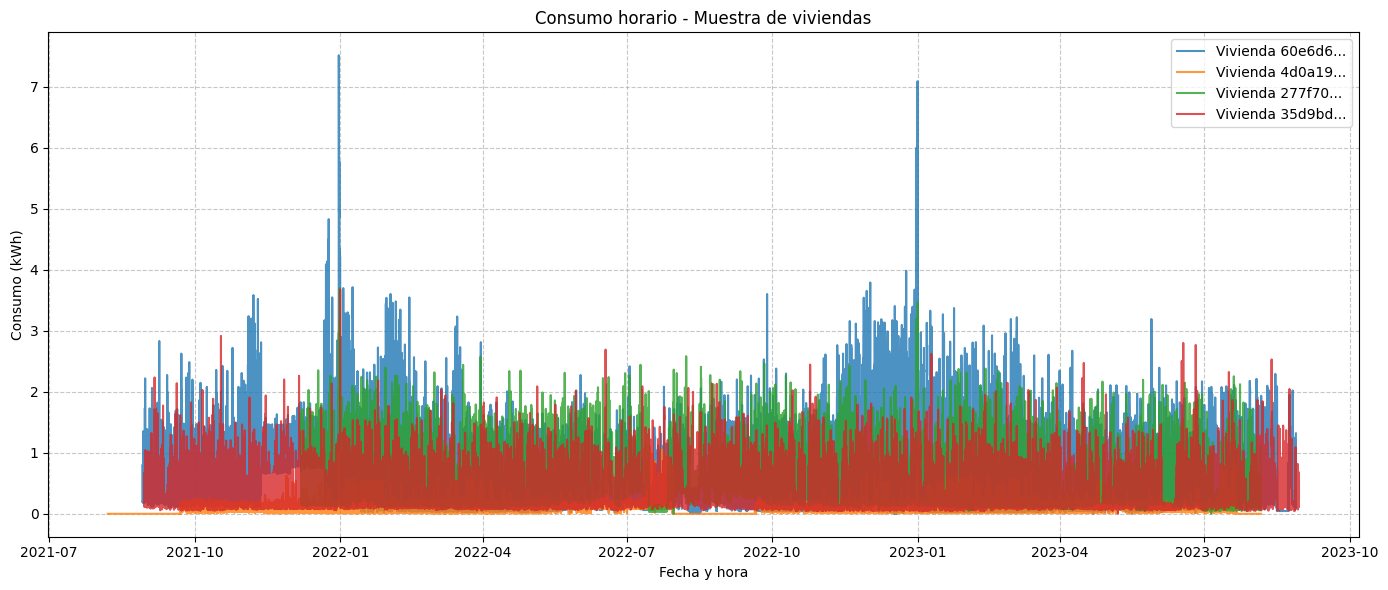

In [15]:
viviendas_sample = df['cups'].drop_duplicates().sample(4, random_state=42)
plt.figure(figsize=(14, 6))

for i, vivienda in enumerate(viviendas_sample):
    df_viv = df[df['cups'] == vivienda].sort_values(by=['fecha', 'hora'])
    
    fechas = pd.to_datetime(df_viv['fecha']) + pd.to_timedelta(df_viv['hora'], unit='h')

    plt.plot(fechas, df_viv['consumo_kWh'], 
             label=f'Vivienda {vivienda[:6]}...', 
             alpha=0.8)

plt.title("Consumo horario - Muestra de viviendas")
plt.xlabel("Fecha y hora")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()